In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

import sys
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


measure_sampling_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling')
CD_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density')

if measure_sampling_path not in sys.path:
    sys.path.append(measure_sampling_path)

if CD_path not in sys.path:
    sys.path.append(CD_path)

from Gen_Path_and_AdaptedTrees import *

from CD_knn_NerualNet import *

from IPython.display import display, clear_output

In [2]:
# Generate Brownian motion paths
n_data =  3000
time_steps = 4  # For example, t=0, t=1, t=2, t=3
paths = generate_brownian_motion(num_paths=n_data, time_steps=time_steps, scale=1)

# For conditional density estimation, let X be the time coordinate and Y be the Brownian value.
# One approach is to consider each path as:
# X = [time indices] and Y = [Brownian values]
# Here, we create a dataset where for each time step (except the first), we estimate the conditional density given the previous time.

# Example: use t=1 as X and t=2 as Y (this is a simplification)
X = np.expand_dims(paths[:, 2], axis=1)  # shape: (num_paths, 1)
Y = np.expand_dims(paths[:, 3], axis=1)  # shape: (num_paths, 1)
d_X = 1
d_Y = 1
k = 55

# Concatenate to form a data tensor: first column(s) for X and the remaining for Y.
data = np.concatenate([X, Y], axis=1)  # shape: (num_paths, 2)

# Convert to a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)



Training progress: 0/299
Training progress: 100/299
Training progress: 200/299
Training took 20.12 seconds.
Number of NaN losses encountered: 0


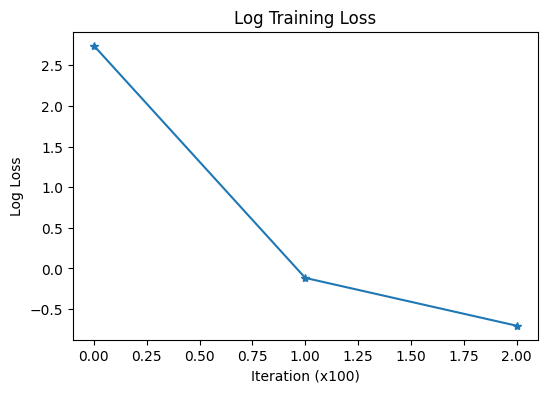

Number of NaN losses encountered: 0


In [3]:
# Train the conditional density estimator.
estimator, loss_hist, n_nan = train_conditional_density(data_tensor, d_X=d_X, d_Y=d_Y, k=55,
                                                             n_iter=300, n_batch=100, lr=1e-3, nns_type=' ')

print("Number of NaN losses encountered: " + str(n_nan))

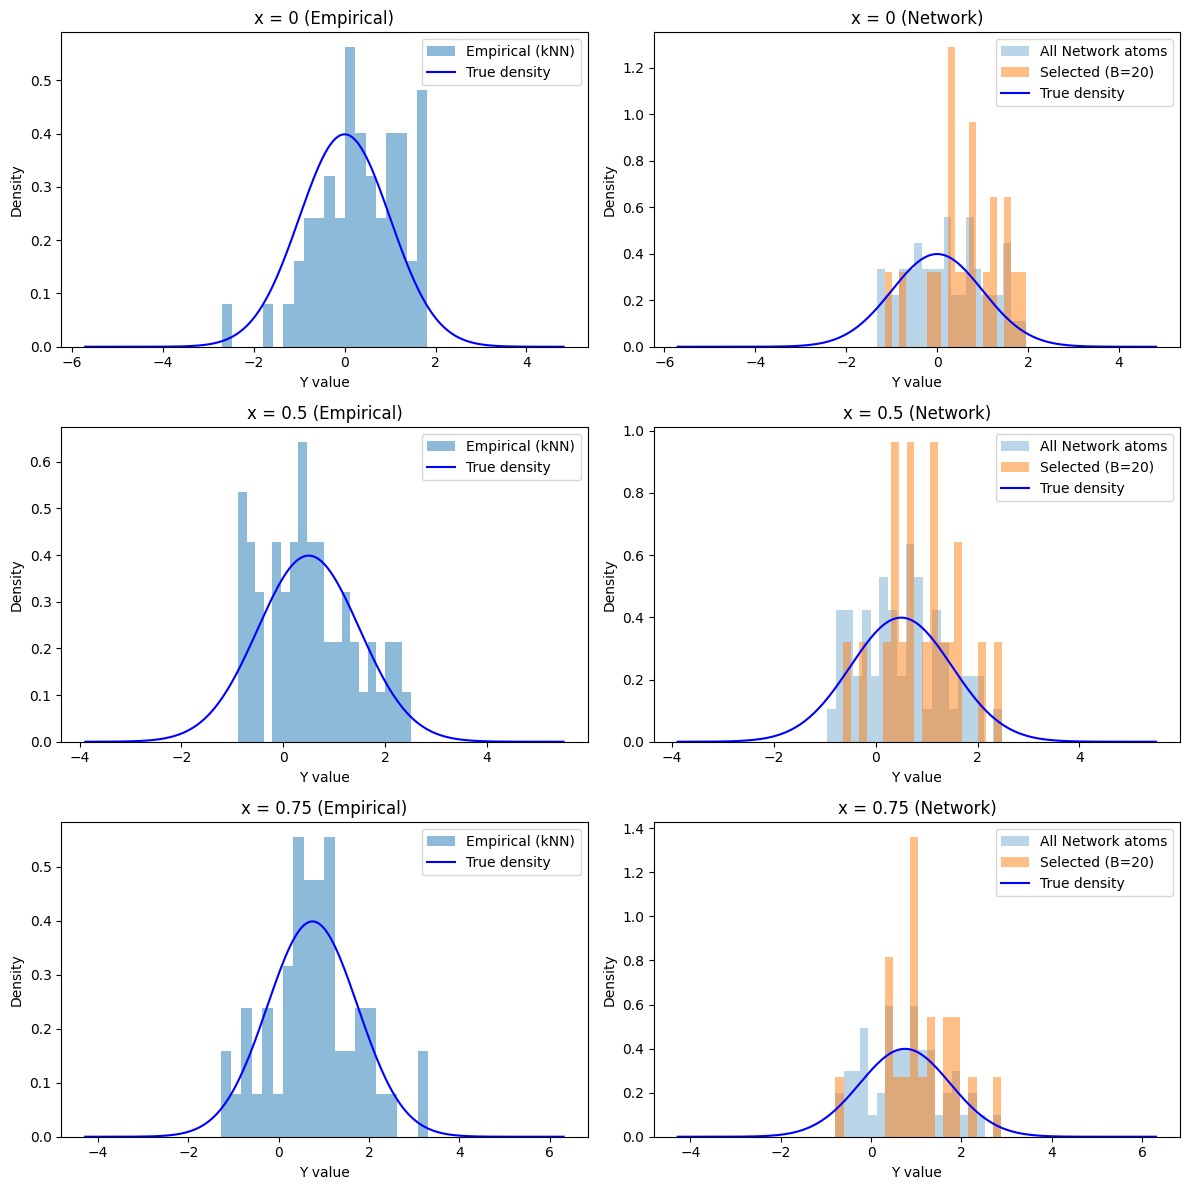

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Evaluate the estimator at a few x values.
x_values = [0, 0.5, 0.75]
B = 20  # choose B atoms out of k
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    
for i, x0 in enumerate(x_values):
    # Get network-predicted atoms.
    all_atoms = evaluate_conditional_density(estimator, x0, B=None)
    selected_atoms = evaluate_conditional_density(estimator, x0, B=B)
        
    # Empirical measure: kNN using data_tensor.
    X_data = data_tensor[:, 0].cpu().numpy()
    Y_data = data_tensor[:, 1].cpu().numpy()
    distances = np.abs(X_data - x0)
    indices = np.argsort(distances)[:55]
    empirical_Y = Y_data[indices]
        
    # True conditional density (assumed Normal with mean=x0, std=1)
    y_min = np.min(empirical_Y) - 3
    y_max = np.max(empirical_Y) + 3
    y_vals = np.linspace(y_min, y_max, 200)
    true_density = norm.pdf(y_vals, loc=x0, scale=1)
        
    # Left plot: Empirical (kNN)
    ax = axs[i, 0]
    ax.hist(empirical_Y, bins=20, density=True, alpha=0.5, label='Empirical (kNN)')
    ax.plot(y_vals, true_density, 'b-', label='True density')
    ax.set_title('x = {} (Empirical)'.format(x0))
    ax.set_xlabel('Y value')
    ax.set_ylabel('Density')
    ax.legend()
    # Right plot: Network atoms (all vs. selected)
    ax = axs[i, 1]
    ax.hist(all_atoms, bins=20, density=True, alpha=0.3, label='All Network atoms')
    ax.hist(selected_atoms, bins=20, density=True, alpha=0.5, label='Selected (B={})'.format(B))
    ax.plot(y_vals, true_density, 'b-', label='True density')
    ax.set_title('x = {} (Network)'.format(x0))
    ax.set_xlabel('Y value')
    ax.set_ylabel('Density')
    ax.legend()
    
plt.tight_layout()
plt.show()
